<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/soft_ware_labs/ase3001_exercises_optimal_planetary_landing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal planetary landing

<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_
_<div style="text-align: right"> Jiwoo Choi (jiwoochoi@inha.edu) </div>_

<br>

In this problem we consider a soft landing problem for a planetary lander.

Consider the following equations of motion in the ENU (East-North-Up) frame

$$
\begin{aligned}
  \dot{p} &= v \\  
  \dot{v} &= u - \gamma v +g  \\
\end{aligned}
$$
with
$$
\begin{aligned}
    p &= (p_e, p_n, p_u)\\
    v &= (v_e, v_n, v_u) \\
        g&=(0,0,-g).
\end{aligned}
$$

where $p$ and $v$ are the position and velocity of the vehicle and $u$ represents the acceleration of the vehicle. The gravitational acceleration is denoted by $g$ and the damping coefficient is given by $\gamma$. Note that the acceleration vector as the control input can be achieved by a set of thrusters attached on the vehicle. The objective of the problem is to find the control input plan $u_0, \dots, u_{N-1}$ that drives the vehicle to $p=0$ and $v=0$ at $t=N$, from the specified initial condition.

<br>

The above system can be descretized using trapezoidal integration as follows.

$$
\begin{aligned}
  v_{t+1} &= v_t + {h}\left( u_t - \gamma v_t -g \right) \\
  &= \left(1-\gamma h\right) v_t + h u_t - hg \\
  p_{t+1} &= p_t + \frac{h}{2}\left( v_t + v_{t+1} \right)  \\
  &= p_t + \frac{h}{2}\left( v_t + \left(1-\gamma h\right) v_t + h u_t \right)  \\
  &= p_t +  \left(h-\frac{1}{2}\gamma h^2\right) v_t + \frac{1}{2} h^2 u_t
\end{aligned}
$$


Given initial points and desired points, the problem of minimizing the control input while satisfying the  dynamics of the system can be defined as follows,

$$
\begin{aligned}
    \text{minimize} \quad & \sum_{t=0}^{N-1} \left\|u_t \right\|_2^2 \\
    \text{subject to} \quad & x_{t+1} = Ax_t + Bu_t+b , \quad t=0,\dots,N-1,\\
    &x_0 = x_\text{init},\\
    &x_N = x_\text{des},
\end{aligned}
$$

where $N$ is the prediction horizon, which represents the number of future time steps considered for the optimization problem.

The above optimal control problem can be addressed using a weighted least squares approach.

In [1]:
import numpy as np
import numpy.linalg as lg

import scipy.sparse as sp
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
from tqdm import tqdm

In [92]:
N = 100
T = 6
dt = T / N
delt = dt
gamma = 1e-5
g     = np.array([0, 0, -9.8])

x_init = np.array([10,-5,40, 0,0,-1])  # initial pe, pn, pu, ve, vn, vu at t=0
x_des  = np.array([0,0,0,0,0,0])      # desired pe, pn, pu, ve, vn, vu at t=N

<br>

---

<br>

_**(Problem 1)**_ Construct the appearing matrices and a vector, $A$, $B$, and $b$ expressed with given parameters. Define $x = (p_e, p_n, p_u, v_e, v_n, v_u)$, and $u=(u_e, u_n, u_u)$.

In [93]:
## your code here ##
A = np.zeros((6,6))
B = np.zeros((6,3))
b = np.zeros(6)
b[-1] = -delt * 9.8
print(b)


A[0,0] = 1
A[1,1] = 1
A[2,2] = 1
A[0,3] = (1-gamma*delt/2)*delt
A[1,4] = (1-gamma*delt/2)*delt
A[2,5] = (1-gamma*delt/2)*delt
A[3,3] = 1 - gamma*delt
A[4,4] = 1 - gamma*delt
A[5,5] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,2] = delt**2/2
B[3,0] = delt
B[4,1] = delt
B[5,2] = delt

[ 0.     0.     0.     0.     0.    -0.588]


<br>

---

<br>

_**(Problem 2)**_
The original problem can be reformulated as minimizing a sum of square terms as follows.

$$
\underset{x_1,\dots,x_N, u_0,\dots,u_{N-1}}{\text{minimize}} \ \|x_N-x_\text{des}\|^2 + \sum_{t=0}^{N-1}\left\| x_{t+1}-Ax_{t}-Bu_{t}-b\right\|^2 + \sum_{t=0}^{N-1}\left\|Q_u u_t\right\|^2.
$$

Stacking the state variables and the control inputs by $x = (x_1,x_2, \dots, x_N)$, $u = (u_0, u_1, \dots, u_{N-1})$, and $y = (x, u) \in \R^{9N}$, the above problem can be expressed as the following,

$$
\underset{y}{\text{minimize}} \ \left\|Gy - c\right\|^2 + \sum_{t=0}^{N-1}\left\|Q_u u_t\right\|^2,
$$

which can again be reformulated in,

$$
\underset{y}{\text{minimize}} \ \left\|\tilde{G}y - \tilde{c}\right\|^2  ,
$$

where, $Q_u$ is a weighting matrix that regulates the size of control inputs, which in given in the code cell below.

<br>

Construct $G, \tilde{G}, c, \tilde{c}$ and make a code implementing these, noting that $G, \tilde{G}, c, \tilde{c}$ contain $A$, $B$, $b$, and $I$ (the identity matrix).

Note that the state variables $x_1, \dots, x_N$ appear in the above formulation. In other words, the decision variables of the above problem include not only the control inputs but also the state variables.

Try using the `scipy.sparse` module with indexing where possible.

풀이:

일단 아래와 같은

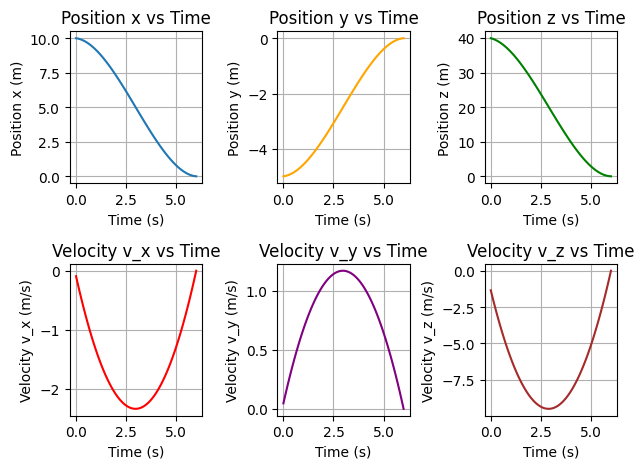

In [94]:
from scipy import sparse

w_u = 3e-2
Q_u = np.diag([w_u]*3)


#G_1
G_1 = np.zeros([6*N,6*N])
for i in range(N):
  if i >= 1:
    G_1[6*i:6*i+6,6*i-6:6*i] =-A
  if i < N-1:
    G_1[6*i:6*i+6,6*i:6*i+6] = np.eye(6)
G_2= np.zeros([6*N,3*N])
for i in range(N):
  G_2[6*i:6*i+6,3*i:3*i+3] = -B

C = np.zeros(len(G_1))
for i in range(N):
  C[6*i:6*i+6] = b

C[:6] = A@x_init +b
C[6*N-6:6*N] =  -x_des +b


G = np.zeros((6*N,9*N))
G[:,:6*N] = G_1
G[:,6*N:] = G_2

Q = np.zeros((3*N,9*N))
for i in range(N):
  Q[3*i:3*i+3,6*N+3*i:6*N+3*i+3] = Q_u

G_tilde = np.zeros((9*N,9*N))
G_tilde[:6*N] = G
G_tilde[6*N:] = Q
C_tilde = np.zeros((9*N))
C_tilde[:6*N] = C
X = np.linalg.lstsq(G_tilde,C_tilde,rcond=None)[0]
x = np.zeros(N)
y= np.zeros(N)
z = np.zeros(N)
v_x = np.zeros(N)
v_y= np.zeros(N)
v_z = np.zeros(N)
for i in range(N):
  x[i] = X[6*i]
  y[i] = X[6*i+1]
  z[i] = X[6*i+2]
  v_x[i] = X[6*i+3]
  v_y[i] = X[6*i+4]
  v_z[i] = X[6*i+5]


time = np.linspace(0, T, N)
plt.subplot(2, 3, 1)
plt.plot(time, x, label='x')
plt.title('Position x vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position x (m)')
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(time, y, label='y', color='orange')
plt.title('Position y vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position y (m)')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(time, z, label='z', color='green')
plt.title('Position z vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position z (m)')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(time, v_x, label='v_x', color='red')
plt.title('Velocity v_x vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity v_x (m/s)')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(time, v_y, label='v_y', color='purple')
plt.title('Velocity v_y vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity v_y (m/s)')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(time, v_z, label='v_z', color='brown')
plt.title('Velocity v_z vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity v_z (m/s)')
plt.grid(True)

plt.tight_layout()
plt.show()


<br>

---

<br>

_**(Problem 3)**_
Find the optimal solution  $y^*$ to the problem using the gradient descent method. Compare this solution with the one obtained via the closed-form solution. Use the initial value `yp_init` specified in the code cell below to achieve faster convergence.

Display the optimal trajectories and the optimal control inputs. Also, check the convergence profile by examining how fast the magnitude of the gradient vectors decreases as the iterations proceed.

In [87]:
xp_init = np.linspace(x_init, x_des, num=N+1, endpoint=True)
yp_init = np.hstack([xp_init[1:].reshape(-1), *[g]*N])[:,None] # initial values

lr = 1e-1
eps_crt = 1e-5  # terminal condition of gradient descent
epochs = 100000

In [103]:
## your code here ##
from scipy import sparse
import jax.numpy as jnp

G_tilde_jax = jnp.array(G_tilde)
C_tilde_jax = jnp.array(C_tilde)
def objective_function(x):
    loss = jnp.linalg.norm(G_tilde_jax @ x - C_tilde_jax)
    return loss

grad_test_function = jax.grad(objective_function)
x =yp_init
grads  = []
x_hist = []

for i in range(epochs):.
    grad = grad_test_function(x)
    grads.append(grad)
    x_hist.append(x)
    if lg.norm(grad) <= eps_crt:
        break

    x_new = x - lr * grad

    x = x_new

x_sol_tf = x

print(f"Optimal x via automatic differentiation and JAX: {x_sol_tf}")
print(f"Norm of the difference: {lgnorm(diff)}")


KeyboardInterrupt: 

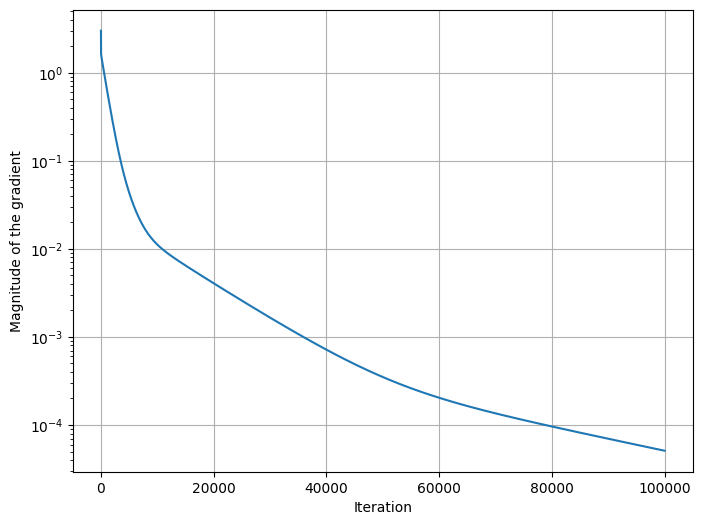

In [ ]:
plt.figure(figsize=(8,6), dpi=100)
plt.semilogy(grads)
plt.xlabel("Iteration")
plt.title("Magnitude of the gradient")
plt.grid()

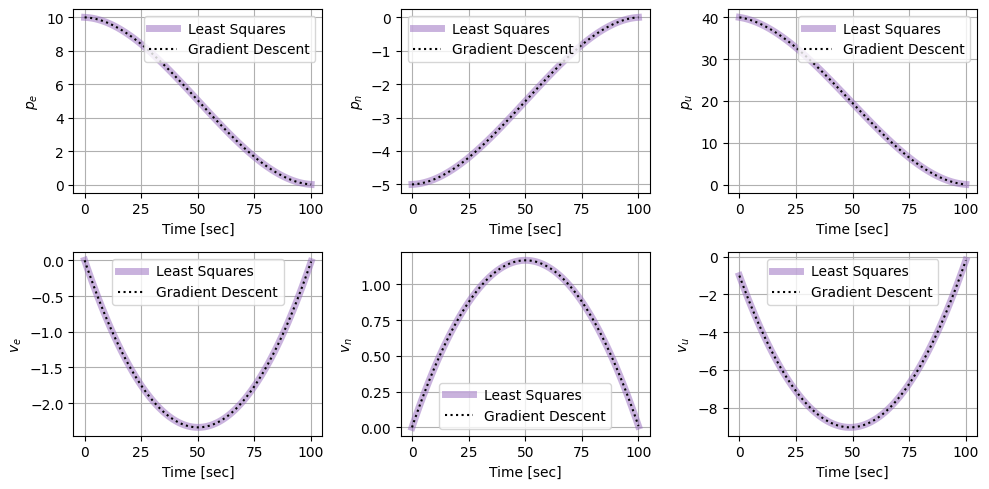

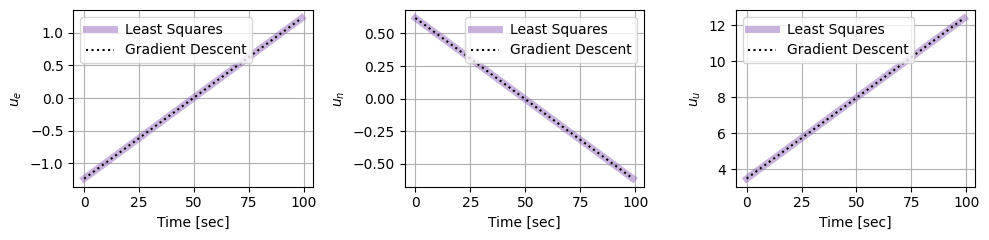

In [ ]:
## your code here ##
